In [20]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [21]:
import numpy as np
import pandas as pd

In [22]:
import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [23]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, distinct

In [24]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [25]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [26]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [27]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [28]:
# Create our session (link) from Python to the DB
session = Session(engine)


In [29]:
# Display the first row's columns and data from Measurement table in dictionary format
first_row = session.query(Measurement).first()
#automap the first row to a dict using this built-in class attribute __dict__
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x14c81e2f898>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [30]:
# Display the first row's columns and data from Station table in dictionary format
first_row = session.query(Station).first()
#automap the first row to a dict using this built-in class attribute __dict__
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x14c81e460b8>,
 'longitude': -157.8168,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1}

# Exploratory Climate Analysis

In [63]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Last record date
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
print(last_date)

# Calculate the date 1 year ago from the last data point in the database
date_last_twelve_months = dt.datetime.strptime(last_date, '%Y-%m-%d') - relativedelta(months=12)
print(date_last_twelve_months.strftime('%Y-%m-%d'))

# Perform a query to retrieve the data and precipitation scores during the last 12 months / Sort by date
data_last_twelve_months = session.query(Measurement.date, Measurement.prcp). \
    filter(Measurement.date >= date_last_twelve_months.strftime('%Y-%m-%d')).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame / set the index to the date column / sort by date
data_last_twelve_months_df = pd.DataFrame(data_last_twelve_months, columns=['Date','Precipitation'])

# Set the index to the date column 
data_last_twelve_months_df.set_index('Date', inplace=True)

# Preview dataframe
data_last_twelve_months_df.head(8)



2017-08-23
2016-08-23


,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
2016-08-23,1.79
2016-08-23,0.70
2016-08-24,0.08


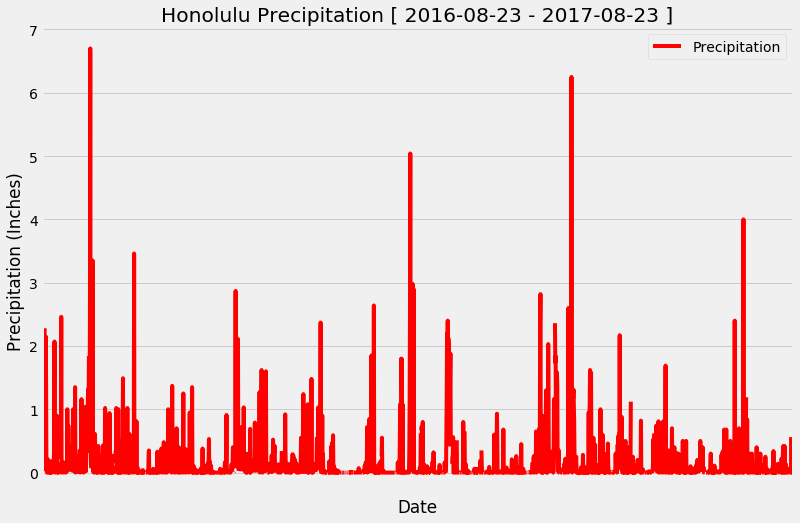

In [58]:
# Use Pandas Plotting with Matplotlib to plot the data
# Set Plot Style
plt.style.use('fivethirtyeight')

# Plot data frame
data_last_twelve_months_df.plot(title='Honolulu Precipitation - Last 12 Months', color='r', figsize=(12,8))

# Set ticks as an empty list
ticks = []

# Hide x's ticks
plt.xticks(ticks)

# Set Plot Labels , Title and Legend
plt.ylabel("Precipitation (Inches)")
plt.xlabel("Date")
plt.title(f"Honolulu Precipitation [ {date_last_twelve_months.strftime('%Y-%m-%d')} - {last_date} ]")
plt.legend()

# Save Figure
#plt.savefig("average_salary_by_title.png")

# Show plot
plt.show()


![precipitation](Images/precipitation.png)

In [33]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data_last_twelve_months_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [34]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(distinct(Measurement.station))).all()
for stat in station_count:
    print(stat)

(9,)


In [35]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
for astat in most_active_stations:
    print(astat)
    


('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [36]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station_records = session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
print(most_active_station_records)

[('USC00519281', 54.0, 85.0, 71.66378066378067)]


In [41]:
# Choose the station with the highest number of temperature observations

last_date_most_active_station_records = session.query(Measurement.date).filter(Measurement.station == 'USC00519281').order_by(Measurement.date.desc()).first().date
print(last_date_most_active_station_records)

2017-08-18


In [42]:
# Calculate the date 12 months ago from the last data point for station with highest number of observations
date_last_twelve_months_macts = dt.datetime.strptime(last_date_most_active_station_records, '%Y-%m-%d') - relativedelta(months=12)
print(date_last_twelve_months_macts.strftime('%Y-%m-%d'))

2016-08-18


In [53]:
# Perform a query to retrieve the last 12 months of temperature observation data for this station / Sort by date
data_last_twelve_months_macts = session.query(Measurement.date, Measurement.tobs). \
    filter(Measurement.date >= date_last_twelve_months_macts.strftime('%Y-%m-%d')).filter(Measurement.station == 'USC00519281').order_by(Measurement.date).all()


In [55]:
# Save the query results as a Pandas DataFrame 
data_last_twelve_months_macts_df = pd.DataFrame(data_last_twelve_months_macts, columns=['Date','Temperature Obs'])

# Set index to Date
data_last_twelve_months_macts_df_index = data_last_twelve_months_macts_df.set_index('Date')

# Preview Data Frame
data_last_twelve_months_macts_df_index.head()


,Temperature Obs
Date,
2016-08-18,80.0
2016-08-19,79.0
2016-08-20,81.0
2016-08-21,79.0
2016-08-22,78.0


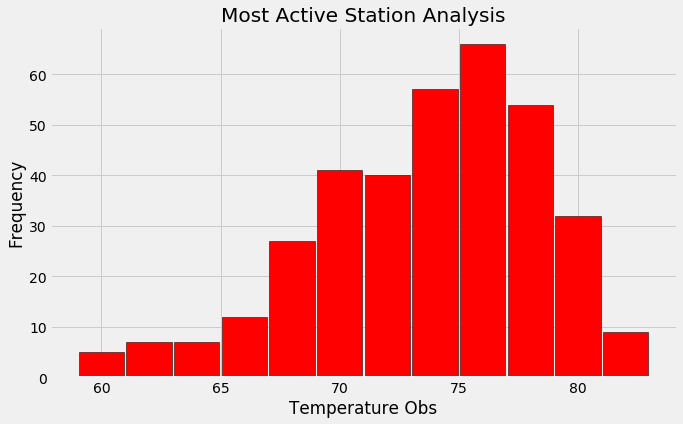

In [57]:
# Set Plot Style
#plt.style.use('fivethirtyeight')

# Create a Histogram Plot using "salary" column 
hist_sht_plot = data_last_twelve_months_macts_df_index['Temperature Obs'].hist(bins=12, rwidth=0.95, edgecolor='black', color='r',figsize=(10,6))

# Set Plot Labels, Title and Legend 
plt.title('Most Active Station Analysis')
plt.xlabel('Temperature Obs')
plt.ylabel('Frequency')


# Save Figure
#plt.savefig("salary_ranges.png")

# Show plot
plt.show()

![precipitation](Images/station-histogram.png)

In [59]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [77]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start_day = '2017-02-28'
trip_end_day = '2017-03-05'
my_trip_temps = calc_temps(trip_start_day, trip_end_day)
print(my_trip_temps)

[(64.0, 72.02777777777777, 78.0)]


64.0 72.02777777777777 78.0


Text(0, 0.5, 'Temp (F)')

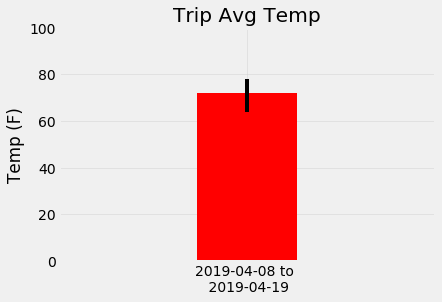

In [81]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

temps_avg = my_trip_temps[0][1]
temps_high = my_trip_temps[0][2]
temps_low = my_trip_temps[0][0]

# Preview temps to make sure index is correct
print(temps_low, temps_avg, temps_high)

# Set Min and Max error values 
min_error = temps_avg - temps_low
max_error = temps_high - temps_avg


error_bars = np.array([[min_error], [max_error]])

plt.bar('2019-04-08 to \n 2019-04-19', temps_avg, yerr=error_bars, color = 'r')
plt.ylim(0, 100)
plt.xlim(-1.5, 1.5)
plt.grid(alpha=.4)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')


In [79]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

station_rain = (session.query(Station.station, Station.name, func.sum(Measurement.prcp), Station.latitude, Station.longitude, Station.elevation)
                   .filter(Station.station == Measurement.station)
                   .filter(Measurement.date >= trip_start_day)
                   .filter(Measurement.date <= trip_end_day)
                   .group_by(Station.station)
                   .order_by(func.sum(Measurement.prcp).desc())
                   .all())

#convert query object to data frame
station_rain_df = pd.DataFrame(np.array(station_rain))
#rename columns
station_rain_df = station_rain_df.rename(columns={0: "Station", 1: "Location", 
                                                    2: "Total Precipitation", 3: "Latitude", 
                                                    4: "Longitude", 5: "Elevation"})
# Preview Data frame
station_rain_df


,Station,Location,Total Precipitation,Latitude,Longitude,Elevation
0,USC00519281,"WAIHEE 837.5, HI US",4.720000000000001,21.45167,-157.84888999999998,32.9
1,USC00513117,"KANEOHE 838.1, HI US",4.45,21.4234,-157.8015,14.6
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",4.07,21.3331,-157.8025,152.4
3,USC00517948,"PEARL CITY, HI US",2.98,21.3934,-157.9751,11.9
4,USC00519397,"WAIKIKI 717.2, HI US",2.7399999999999998,21.2716,-157.8168,3.0
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2.32,21.33556,-157.71139,19.5
6,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",1.1600000000000001,21.5213,-157.8374,7.0


## Optional Challenge Assignment